In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             roc_curve, ConfusionMatrixDisplay)

# 1. Configuração de Diretórios
os.makedirs('docs', exist_ok=True)
os.makedirs('results', exist_ok=True)

In [12]:
df.head()

,energy,tempo,danceability,playlist_genre,loudness,liveness,valence,track_artist,time_signature,speechiness,...,track_album_id,mode,key,duration_ms,acousticness,id,playlist_subgenre,type,playlist_id,hit_potencial
0,0.592,157.969,0.521,pop,-7.777,0.122,0.535,"Lady Gaga, Bruno Mars",3,0.0304,...,10FLjwfpbxLmW8c25Xyc2N,0,6,251668,0.3080,2plbrEY59IikOBgBGLjaoe,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M,1
1,0.507,104.978,0.747,pop,-10.171,0.117,0.438,Billie Eilish,4,0.0358,...,7aJuG4TFXa2hmE4z1yxc3n,1,2,210373,0.2000,6dOtVTDdiauQNBQEDOtlAB,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M,1
2,0.808,108.548,0.554,pop,-4.169,0.159,0.372,Gracie Abrams,4,0.0368,...,0hBRqPYPXhr1RkTDG3n4Mk,1,1,166300,0.2140,7ne4VBA60CxGM75vw0EYad,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M,1
3,0.910,112.966,0.670,pop,-4.070,0.304,0.786,Sabrina Carpenter,4,0.0634,...,4B4Elma4nNDUyl6D5PvQkj,0,0,157280,0.0939,1d7Ptw3qYcfpdLNL5REhtJ,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M,1
4,0.783,149.027,0.777,pop,-4.477,0.355,0.939,"ROSÉ, Bruno Mars",4,0.2600,...,2IYQwwgxgOIn7t3iF6ufFD,0,0,169917,0.0283,5vNRhkKd0yEAg8suGBpjeY,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M,1


In [13]:
# 2. Carga de Dados
df = pd.read_csv('high_popularity_spotify_data.csv')

In [14]:
# 3. Engenharia de Features e Target
# Regra: Hit se popularidade >= 80
df['hit_potencial'] = (df['track_popularity'] >= 80).astype(int)

In [15]:
# Seleção de colunas de áudio
features = ['energy', 'danceability', 'loudness', 'valence',
            'speechiness', 'instrumentalness', 'acousticness',
            'tempo', 'liveness']

X = df[features]
y = df['hit_potencial']

In [16]:
# 4. Pré-processamento (Escalonamento é vital para KNN)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Divisão Treino/Teste
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

In [17]:
# 5. Treinamento com Otimização de Hiperparâmetros
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': list(range(3, 21, 2))} # Testa k impares de 3 a 19

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_k = grid_search.best_params_['n_neighbors']

In [18]:
# 6. Avaliação
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

metrics = {
    "accuracy": round(accuracy_score(y_test, y_pred), 4),
    "precision": round(precision_score(y_test, y_pred, zero_division=0), 4),
    "recall": round(recall_score(y_test, y_pred), 4),
    "f1_score": round(f1_score(y_test, y_pred), 4),
    "roc_auc": round(roc_auc_score(y_test, y_proba), 4),
    "best_k": int(best_k)
}

In [19]:
# 7. Geração e Salvamento de Gráficos

# A. Distribuição do Target
plt.figure(figsize=(6, 4))
sns.countplot(x='hit_potencial', data=df, palette='viridis')
plt.title('Distribuição de Hit Potencial (Pop >= 80)')
plt.savefig('docs/distribuicao_target.png')
plt.close()

/tmp/ipython-input-1984394779.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='hit_potencial', data=df, palette='viridis')


In [20]:
# B. Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Não Hit', 'Hit'])
disp.plot(cmap='Blues')
plt.title(f'Matriz de Confusão (KNN k={best_k})')
plt.savefig('docs/matriz_confusao.png')
plt.close() # Para não sobrepor plots

In [21]:
# C. Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"KNN (AUC = {metrics['roc_auc']})", color='green')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.savefig('docs/curva_roc.png')
plt.close()

In [22]:
df["playlist_genre"].value_counts()

,count
playlist_genre,
pop,357
rock,235
hip-hop,227
latin,184
electronic,148
gaming,100
ambient,61
r&b,50
arabic,50


In [32]:
X_full_scaled = scaler.transform(X)
df['prob_hit'] = best_model.predict_proba(X_full_scaled)[:, 1]

# get top predicted hit
top_hit = df.sort_values("prob_hit", ascending=False).iloc[0]

top_hit

,5
energy,0.582
tempo,116.712
danceability,0.7
playlist_genre,pop
loudness,-5.96
liveness,0.0881
valence,0.785
track_artist,Chappell Roan
time_signature,4
speechiness,0.0356


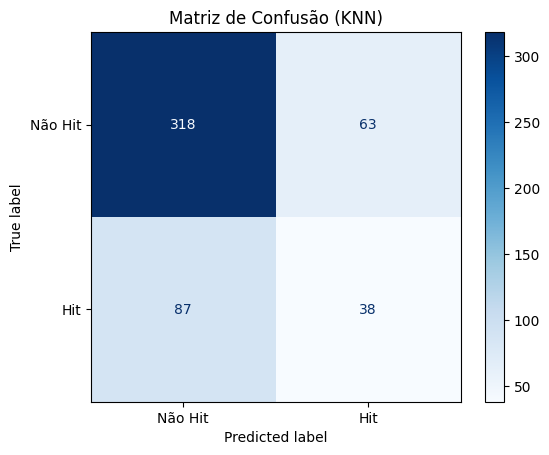

In [23]:
# Gera a matriz visualmente
disp = ConfusionMatrixDisplay.from_estimator(
    best_model,
    X_test,
    y_test,
    display_labels=['Não Hit', 'Hit'],
    cmap='Blues',
    normalize=None # Use 'true' se quiser ver em porcentagem
)

plt.title(f"Matriz de Confusão (KNN)")
plt.show()

In [24]:
# Calcula as probabilidades da classe positiva (Hit)
y_proba = best_model.predict_proba(X_test)[:, 1]

In [25]:
# Calcula os pontos da curva
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

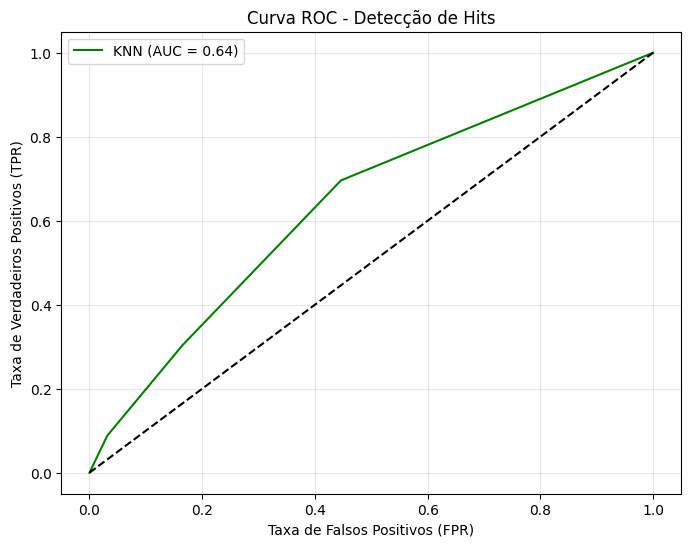

In [26]:
# Plota o gráfico
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', label=f'KNN (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='black', linestyle='--') # Linha de base (aleatória)
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Detecção de Hits')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [28]:
from sklearn.metrics import classification_report

# 1. Relatório completo do Sklearn
y_pred = best_model.predict(X_test)
print("=== Relatório de Classificação ===")
print(classification_report(y_test, y_pred, target_names=['Não Hit', 'Hit']))

=== Relatório de Classificação ===
              precision    recall  f1-score   support

     Não Hit       0.79      0.83      0.81       381
         Hit       0.38      0.30      0.34       125

    accuracy                           0.70       506
   macro avg       0.58      0.57      0.57       506
weighted avg       0.68      0.70      0.69       506



In [29]:
# 2. Ver o dicionário de resultados que seria exportado
print("\n=== Dicionário de Métricas ===")
print(metrics)  # Variável criada no passo anterior


=== Dicionário de Métricas ===
{'accuracy': 0.7036, 'precision': 0.3762, 'recall': 0.304, 'f1_score': 0.3363, 'roc_auc': np.float64(0.6377), 'best_k': 3}
